<a href="https://colab.research.google.com/gist/Gora6988/8f57c62d11aaf483e81cfad3f4dabd62/-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Метчинг товаров

**Цель проекта:**

разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

оценить качество алгоритма по метрике accuracy@5


**Описание данных**<br/>
base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу.

**Содержание проекта:**


1.   Загрузка и обработка данных
2.   Определение параметров для метода KNN
3.   Разбиение на кластеры и поиск ближайших значений
4.   Подбор соседей методом KNN
5.   Заключение





#1. Загрузка и обработка данных

In [1]:
!pip install phik

импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import phik
from phik.report import plot_correlation_matrix
from phik import report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

Загрузка данных

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')

In [4]:
df_train.head(5)

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [5]:
df_train.head(5)

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [6]:
df_valid = pd.read_csv('/content/drive/MyDrive/validation.csv')

In [7]:
df_valid.head(5)

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [8]:
valid_answers = pd.read_csv('/content/drive/MyDrive/validation_answer.csv')

In [9]:
valid_answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        100000 non-null  object
 1   Expected  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [10]:
valid_answers.head(5)

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


In [11]:
base = pd.read_csv('/content/drive/MyDrive/base.csv')

In [12]:
base

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.666340,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.202110,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.566180,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.202890,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.766320,-2.505783,65.315285,135.051590,-1074.464888,0.319401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918134,4744755-base,-125.086300,4.735448,38.284935,-125.27671,209.788360,-47.870010,-628.127378,-71.077340,125.534355,...,-70.364395,55.428260,-191.53702,122.978279,65.515260,108.963715,-52.795380,117.254510,-615.998268,-77.768555
2918135,4744759-base,-108.598390,5.454173,-22.191975,-158.71666,113.606110,-88.843430,-117.234538,137.317690,129.056690,...,-70.360190,18.439003,-90.65145,-28.586794,68.691666,1.636499,-24.388298,93.530540,-1074.464888,-90.800400
2918136,4744762-base,-97.026730,-2.143885,-71.274090,-144.68066,149.464810,-21.572212,-759.626065,-108.151955,124.810135,...,-55.961933,62.923470,-169.11832,108.452806,68.592970,43.205433,69.029830,129.536650,-1074.464888,4.718300
2918137,4744763-base,-86.838430,8.911945,-34.837738,-106.46268,42.236572,-96.194230,-532.907338,9.845185,126.037560,...,-86.867020,-6.959065,-174.07591,-151.007973,68.622246,0.707927,94.451866,124.843000,-1074.464888,-55.789314


обрботка данных


In [13]:
valid_answers = pd.DataFrame(valid_answers)
valid_answers = valid_answers.rename(columns={'Expected':'Target'})

In [14]:
features_train = df_train.drop(['Target'],axis=1)

In [15]:
target_train = df_train['Target']

По причине сильно разброса значений произведем нормализацию данных

In [16]:
scaler = StandardScaler()
base_scaled = scaler.fit_transform(base.drop('Id',axis=1))
df_valid_scaled = scaler.transform(df_valid.drop('Id',axis=1))
features_train_scaled = scaler.transform(features_train.drop('Id',axis=1))

преобразуем данные в датафреймы

In [17]:
base_scaled = pd.DataFrame(base_scaled)
df_valid_scaled = pd.DataFrame(df_valid_scaled)
features_train_scaled = pd.DataFrame(features_train_scaled)

In [18]:
base_scaled

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,-0.282884,0.373663,-0.435627,0.884544,...,1.189049,0.190524,0.073589,-0.894789,-2.262493,-0.510438,0.293004,-0.014051,1.781420,-0.312329
1,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,1.130652,-0.871900,-0.623903,1.098487,...,-1.272135,0.270119,-0.073569,-1.097493,0.225102,0.014491,1.711283,0.059848,1.853726,-0.281052
2,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,1.637293,0.654489,0.828686,0.619635,...,0.086191,0.440159,-1.269686,1.143739,-1.220546,0.773022,0.099669,0.048521,-0.713847,0.365623
3,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,0.033281,-0.840347,-0.259958,0.182763,...,0.274980,-1.372853,0.184217,-0.523936,-0.871349,-0.797073,1.014714,0.090076,-0.713847,-0.601807
4,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,-0.020200,0.386656,-0.238677,-0.191508,...,0.716557,0.808178,-0.110496,0.725544,-0.562342,-0.470720,-0.157210,0.920175,-0.713847,1.152406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918134,-1.561060,-0.675221,2.145022,1.076266,2.124613,0.855791,-0.868394,-1.423783,0.291078,-1.476259,...,0.284290,0.766146,-0.891135,1.099805,-1.248473,1.543466,-2.082561,0.079706,0.475699,-0.718053
2918135,-0.898663,-0.530123,0.579546,-0.608808,0.049398,-0.597886,1.012274,1.821418,0.845243,0.625420,...,0.284428,-0.514378,1.555805,-0.431911,0.493593,-0.395871,-1.619490,-1.040661,-0.713847,-1.030208
2918136,-0.433776,-2.064035,-0.690969,0.098481,0.823080,1.788798,-1.352459,-2.001122,0.177137,-0.088426,...,0.757178,1.025621,-0.347378,0.953011,0.439465,0.355254,-0.096658,0.659732,-0.713847,1.257774
2918137,-0.024465,0.167939,0.252204,2.024324,-1.490462,-0.858682,-0.517876,-0.163629,0.370246,-1.012485,...,-0.257554,-1.393629,-0.467622,-1.669100,0.455521,-0.412650,0.317753,0.438073,-0.713847,-0.191579


In [19]:
df_valid_scaled

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,0.115241,0.676228,0.275453,0.453766,0.817488,0.693550,0.597167,-0.020121,-0.777845,-1.659674
1,1.304502,0.950910,0.033969,0.615646,0.067603,-0.657373,-1.352459,0.679613,0.540216,-1.107069,...,-0.013756,-0.142350,-0.334949,-0.980522,1.631021,-1.617587,0.360549,0.369533,0.142436,0.545701
2,0.886027,-2.434901,0.955216,-1.185496,-0.320843,0.341078,-1.352459,1.045290,1.193478,0.690080,...,-1.831225,0.140946,-0.118026,-1.347979,-0.044550,1.128563,1.021715,1.204944,1.311027,-0.555197
3,-0.524576,1.623911,1.408637,-0.071830,-0.595916,-2.190385,1.659459,-0.613543,-1.359610,-0.764409,...,0.058666,0.373992,0.540055,-1.217473,1.695934,0.000596,0.949135,1.307485,-0.000064,-0.996489
4,0.269032,-1.704743,0.739119,-1.221980,1.168059,1.550401,1.568739,0.218922,0.821217,-0.347213,...,-1.469227,0.427148,0.498123,-0.004204,1.549868,-0.148400,1.297723,-0.654827,-0.966634,-1.856774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.589176,-0.289879,1.344941,1.537359,-0.674999,0.842355,1.378686,1.367212,-0.150169,-0.323048,...,0.439374,1.022174,0.143790,-0.814081,-0.437841,0.957303,-0.137479,-0.155512,1.613758,-0.838686
99996,-0.343768,0.559732,1.508635,1.058998,-1.936880,-0.625634,1.737881,-1.041262,-0.016599,-0.782626,...,0.459344,0.163484,0.998530,-0.329332,-1.990528,-2.540145,0.310819,-1.383091,-1.225086,-0.376062
99997,1.084917,1.111515,1.740436,0.590027,0.731186,0.309134,1.039623,-0.063464,0.702601,0.688763,...,0.991457,0.220952,0.132423,1.480110,2.066273,0.030580,-1.808538,-0.833142,2.263597,0.472120
99998,2.124269,0.725004,0.336589,0.964536,-0.771030,1.258890,-1.352459,-1.566179,0.004354,-1.420372,...,0.410774,-0.605988,0.284299,1.253559,0.238116,1.661690,-1.834984,1.607630,1.624929,-0.314550


In [20]:
features_train_scaled

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.866975,1.274319,-0.024410,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963
1,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,1.095696,-1.538329,0.193777,0.246358,...,1.254600,-0.991073,0.075152,-0.159574,0.207972,0.028031,0.244774,0.709459,-0.611690,-0.083491
2,1.456328,-0.855696,-1.851792,-1.701553,1.700433,0.750504,1.543015,-0.791080,0.328335,1.352615,...,0.886224,1.548929,-0.348054,0.687136,-0.978114,-0.092956,2.240614,0.300576,-0.713847,0.604677
3,1.543467,0.203199,-1.833235,1.291201,-0.359536,-1.322073,-1.409605,0.916179,0.050167,1.834418,...,0.573141,0.388351,0.227494,0.806859,-2.007464,1.491032,0.133987,0.128028,-0.713847,0.668019
4,0.265046,1.284537,-0.370748,-0.021041,-1.169187,1.977993,0.261015,0.399148,0.355099,-0.326947,...,0.336621,0.406133,-1.001615,-1.331745,-0.474647,0.341715,0.043401,-1.090276,-0.713847,0.638160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.725110,0.722221,-0.481442,-2.121036,0.427126,0.243597,-0.449294,1.177860,-0.774538,-2.019131,...,0.840573,0.182656,0.526545,-0.001117,-0.720830,-1.078627,-0.216310,-0.402772,-0.713847,0.303320
99996,0.790982,-1.186858,-0.665550,0.023540,-0.722780,0.868008,1.005795,-0.709106,1.229618,0.912654,...,-1.169178,0.000956,1.072533,-0.996450,-1.082383,-0.972380,0.958916,1.838433,-0.895797,-1.458088
99997,1.296887,-0.676949,0.396096,-0.027606,3.296232,-1.033995,-0.130019,0.742875,-0.881030,1.055263,...,0.137449,-1.642466,-0.724428,0.089136,-0.243436,1.570089,-0.638580,-0.186539,0.219093,1.042461
99998,0.357864,0.411899,-0.502547,1.552935,0.622546,-0.811189,-1.047148,1.632550,-0.897114,1.131146,...,-3.430371,0.846477,-0.772004,-1.091062,-0.880503,-1.145375,-0.294394,-0.229692,-0.713847,-0.759407


##2. Определение параметров для метода KNN

построим матрицу коэффициентов корреляции

In [21]:
phik_overview = features_train_scaled[:10_000].phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1.00,0.00,0.05,0.05,0.08,0.09,0.03,0.05,0.04,0.09,...,0.00,0.01,0.01,0.05,0.09,0.05,0.09,0.00,0.05,0.05
1,0.00,1.00,0.07,0.07,0.06,0.00,0.06,0.06,0.01,0.00,...,0.06,0.00,0.07,0.02,0.08,0.06,0.01,0.16,0.04,0.04
2,0.05,0.07,1.00,0.07,0.09,0.00,0.04,0.03,0.08,0.09,...,0.07,0.15,0.09,0.00,0.11,0.07,0.05,0.10,0.03,0.00
3,0.05,0.07,0.07,1.00,0.06,0.08,0.00,0.06,0.08,0.06,...,0.05,0.06,0.07,0.00,0.08,0.06,0.00,0.07,0.06,0.06
4,0.08,0.06,0.09,0.06,1.00,0.00,0.05,0.07,0.07,0.10,...,0.06,0.13,0.09,0.02,0.08,0.07,0.06,0.06,0.00,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.05,0.06,0.07,0.06,0.07,0.07,0.05,0.04,0.07,0.05,...,0.11,0.10,0.06,0.03,0.00,1.00,0.00,0.05,0.00,0.08
68,0.09,0.01,0.05,0.00,0.06,0.05,0.07,0.22,0.05,0.08,...,0.03,0.08,0.09,0.00,0.06,0.00,1.00,0.08,0.02,0.09
69,0.00,0.16,0.10,0.07,0.06,0.15,0.00,0.06,0.07,0.03,...,0.07,0.03,0.07,0.00,0.08,0.05,0.08,1.00,0.06,0.02
70,0.05,0.04,0.03,0.06,0.00,0.08,0.11,0.00,0.05,0.04,...,0.05,0.01,0.06,0.02,0.00,0.00,0.02,0.06,1.00,0.04


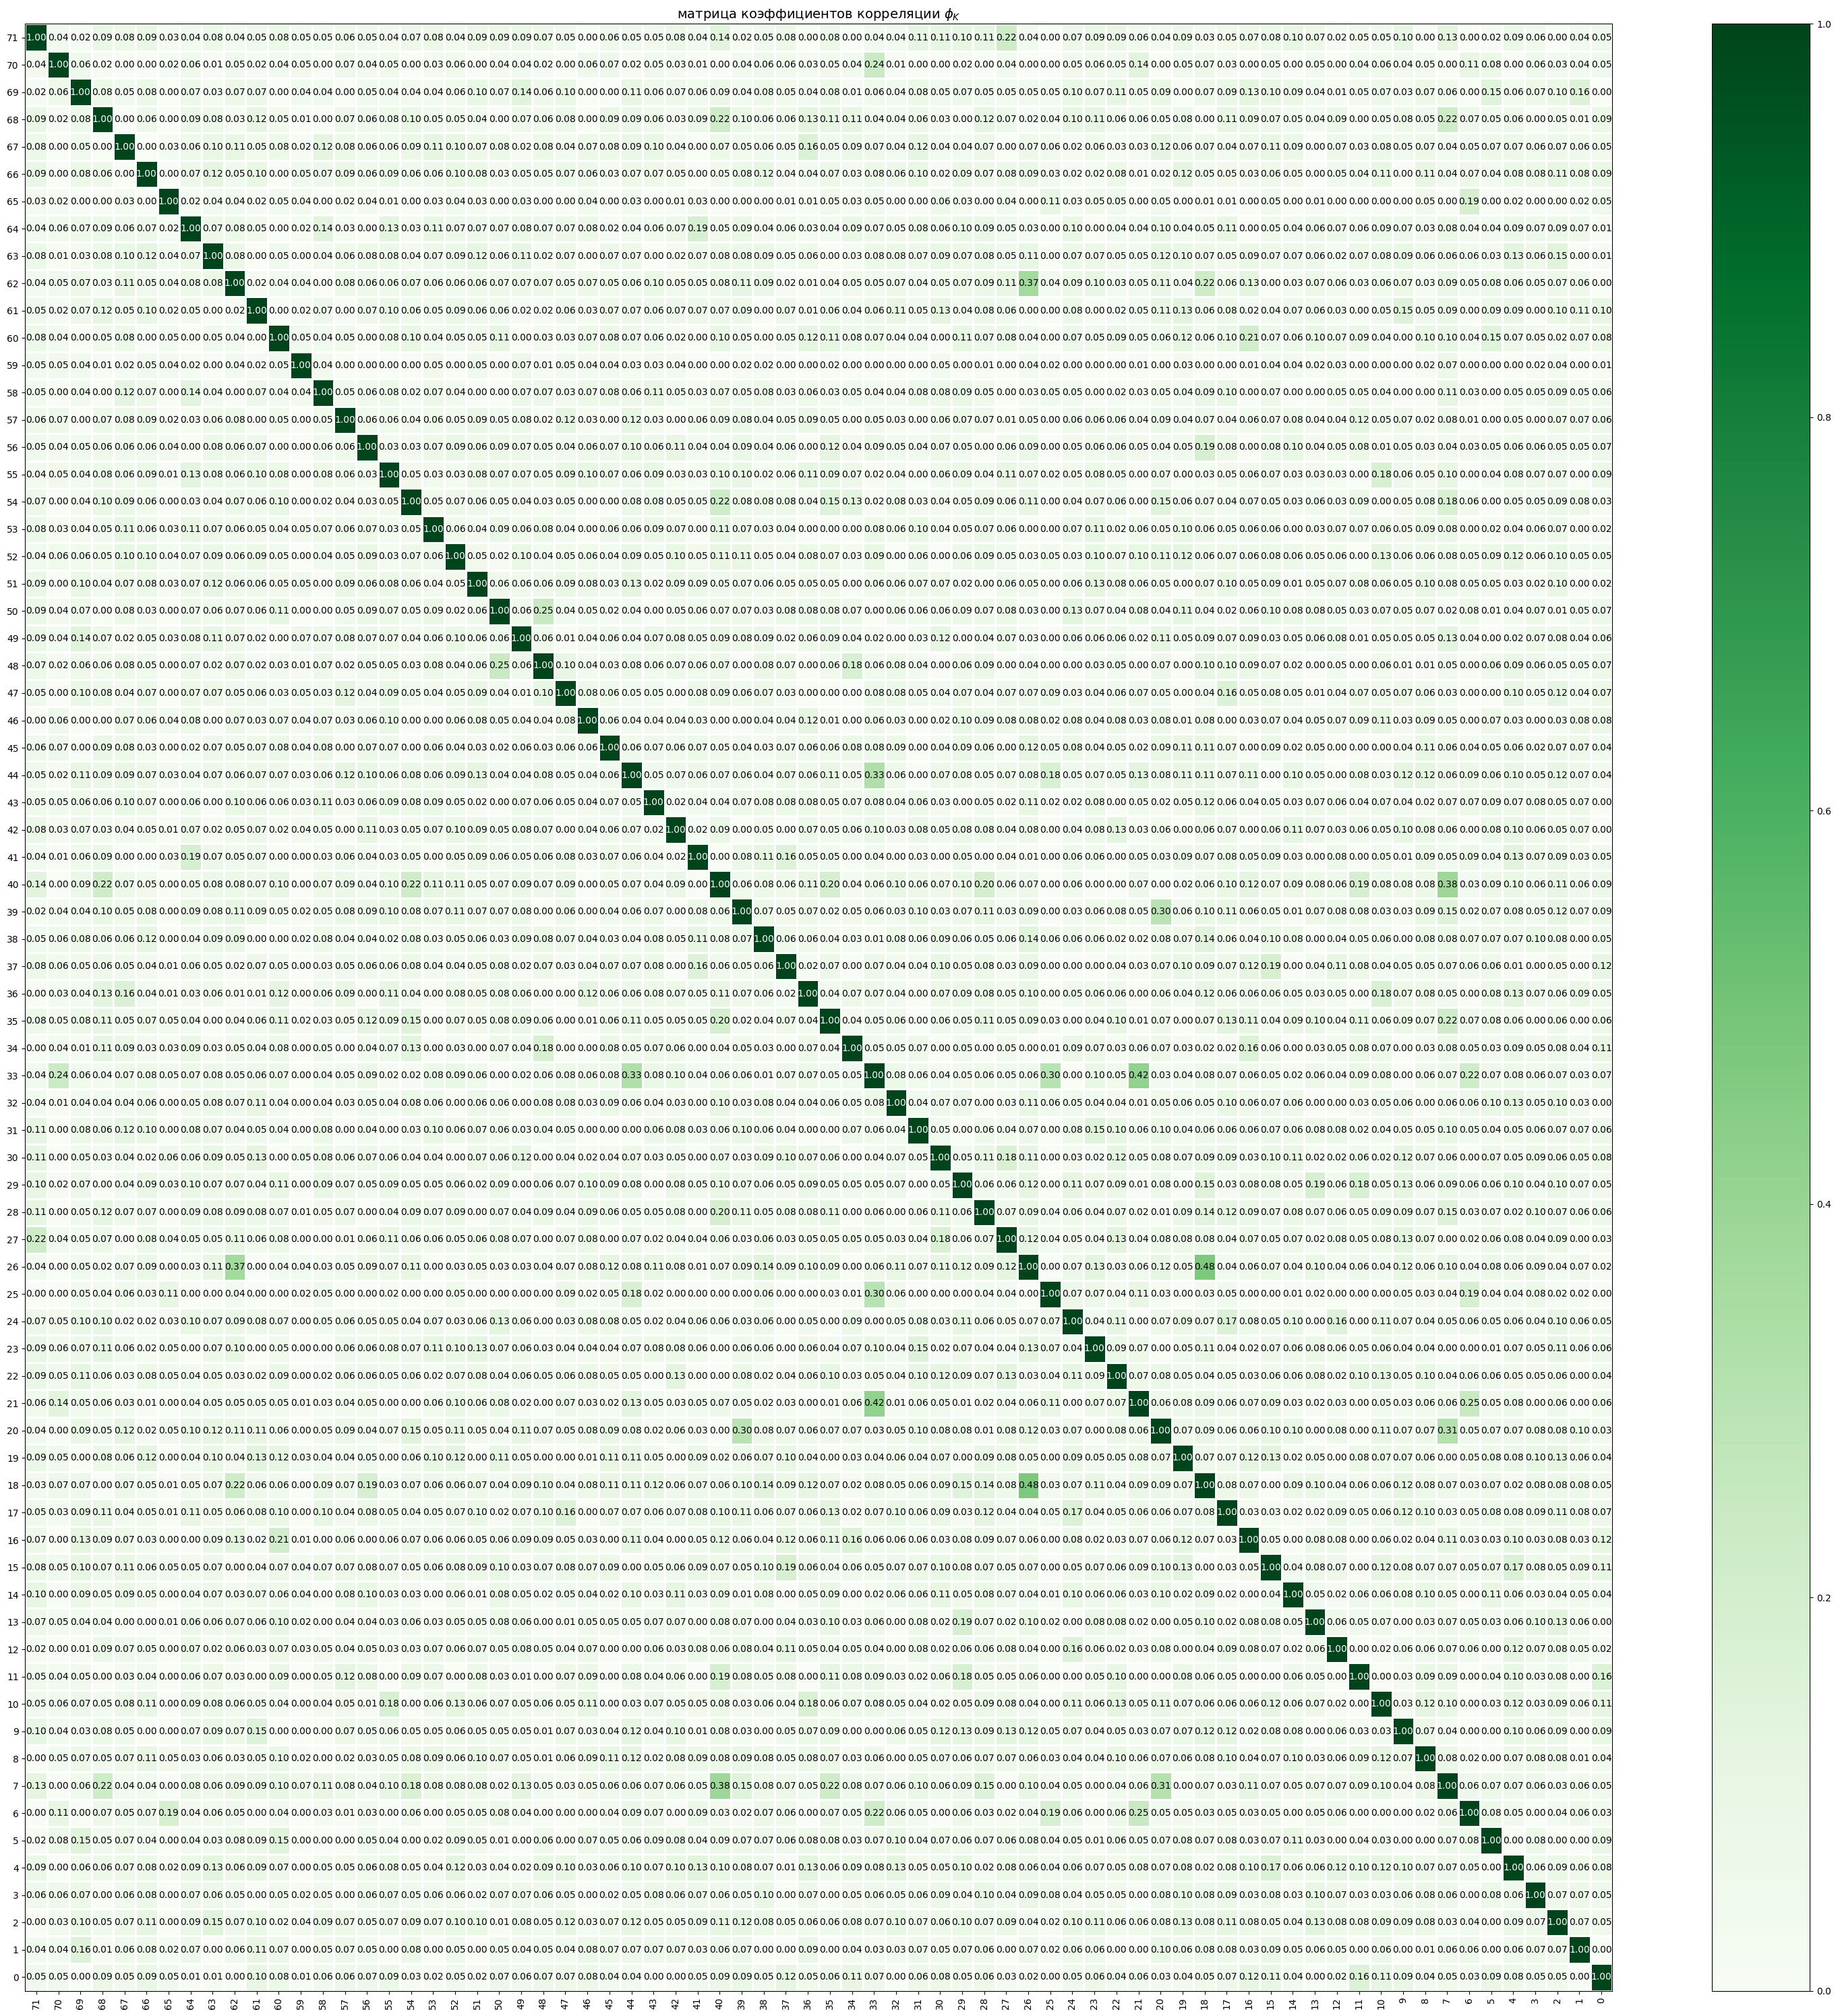

In [22]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"матрица коэффициентов корреляции $\phi_K$",
                        fontsize_factor=1,
                        figsize=(30, 30))

plt.tight_layout()

сильной корреляции признаков не наблюдается

Используя метод локтя определим подходящие кол-во кластеров

In [23]:

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1,201,20)

for k in K:
    # построение и обучение модели
    kmeanModel = KMeans(n_clusters=k).fit(features_train_scaled[:10_000])
    kmeanModel.fit(features_train_scaled[:10_000])

    distortions.append(sum(np.min(cdist(features_train_scaled[:10_000], kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / features_train_scaled[:10_000].shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(features_train_scaled[:10_000], kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / features_train_scaled[:10_000].shape[0]
    mapping2[k] = kmeanModel.inertia_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

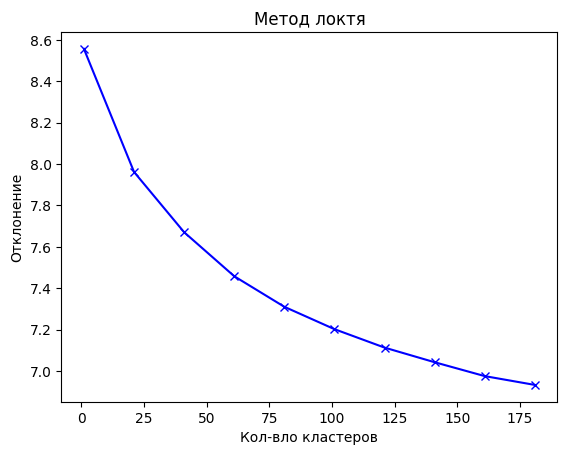

In [24]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Кол-вло кластеров')
plt.ylabel('Отклонение')
plt.title('Метод локтя')
plt.show()

из графика видно что после 80 кластеров отклонение уменьшается незначительно, поэтому выберем это значение

##3. Разбиение на кластеры и поиск ближайших значений

создадим модель Kmeans с 80 кластерами

In [ ]:
model_kmeans = KMeans(n_clusters=80)

обучим модель

In [ ]:
model_kmeans.fit(base_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=80)

запишем кластера и их центры в переменные

In [ ]:
labels = model_kmeans.labels_
centers = model_kmeans.cluster_centers_

In [ ]:
base_scaled = pd.DataFrame(base_scaled)

добавим номер кластера в базу

In [ ]:
base_scaled['cluster'] = labels

In [ ]:
base_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,cluster
0,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,-0.282884,0.373663,-0.435627,0.884544,...,0.190524,0.073589,-0.894789,-2.262493,-0.510438,0.293004,-0.014051,1.781420,-0.312329,41
1,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,1.130652,-0.871900,-0.623903,1.098487,...,0.270119,-0.073569,-1.097493,0.225102,0.014491,1.711283,0.059848,1.853726,-0.281052,29
2,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,1.637293,0.654489,0.828686,0.619635,...,0.440159,-1.269686,1.143739,-1.220546,0.773022,0.099669,0.048521,-0.713847,0.365623,47
3,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,0.033281,-0.840347,-0.259958,0.182763,...,-1.372853,0.184217,-0.523936,-0.871349,-0.797073,1.014714,0.090076,-0.713847,-0.601807,2
4,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,-0.020200,0.386656,-0.238677,-0.191508,...,0.808178,-0.110496,0.725544,-0.562342,-0.470720,-0.157210,0.920175,-0.713847,1.152406,46


посмотрим данные с центройдами кластеров

In [ ]:
centers_inf = pd.DataFrame(centers)

In [ ]:
centers_inf

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,-0.120101,-0.006430,0.176905,-0.183494,-0.206487,0.355251,-0.183250,0.464832,-0.558043,0.229513,...,0.163653,0.103912,0.529405,0.026206,0.705352,-0.126766,-0.375725,0.067308,0.269928,-0.284134
1,0.600975,-1.460062,1.521553,-0.200043,-0.540096,-0.485010,0.127427,0.230669,-0.841904,1.451188,...,0.752879,0.948702,-0.564868,-0.000144,-1.005780,1.134377,1.522821,-0.374897,-0.175737,-0.681815
2,0.449372,0.036435,-0.455664,-0.352810,-0.866775,-0.136158,-0.013555,-0.224145,-0.294767,0.277122,...,-0.010457,0.015866,-0.276976,0.002590,0.448807,-0.349321,0.912600,0.129027,0.042258,-0.832693
3,-0.729525,0.247668,-0.324756,-0.884028,1.367249,-0.022423,0.163049,-0.266196,0.567742,-0.989750,...,-0.214517,-0.839778,0.508914,-0.027855,-1.460377,1.011674,1.751633,-0.518777,0.316956,0.093532
4,-0.140986,0.768057,0.538401,1.214641,0.514127,0.773836,-0.041670,-0.201785,0.296145,0.134734,...,-0.138667,-0.031472,0.160941,-0.010030,-0.022216,0.201570,0.660723,0.111442,0.058919,-0.191611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.580877,0.744184,-1.683202,-0.283575,0.030912,-1.484226,-0.025451,-0.838796,-0.821849,1.284976,...,-0.268025,-1.093372,-1.493022,-0.013555,-0.692015,1.094732,-0.740497,-1.614775,-0.227879,0.025076
76,-0.432472,-0.510035,1.394662,-1.380410,-0.155601,-0.368277,0.175148,-1.930615,-0.702851,0.923572,...,0.294496,-0.130023,-1.572389,-0.005457,0.876566,0.797536,-1.163588,-0.339827,-0.578684,-1.703788
77,-0.603541,0.655979,-0.379447,-0.495395,-0.064499,0.451432,0.188677,-0.568237,0.442213,0.774457,...,0.877538,-0.156807,-0.189244,0.009901,-0.282544,-0.676111,-1.049431,0.275089,-0.683317,0.212740
78,0.774201,-0.651951,0.168614,0.344333,-0.235956,0.125733,-0.042285,-0.298658,-0.151772,-0.312481,...,0.734209,-0.636550,0.046172,-0.007369,-0.205304,-1.023593,1.117839,-0.144631,0.063195,0.422256


для обучающих и валидационных данных найдем и запишем кластер с ближайшим соседом из базы

In [ ]:
knn = NearestNeighbors(n_neighbors=1)

In [ ]:
knn.fit(centers_inf)

NearestNeighbors(n_neighbors=1)

In [ ]:
distances, indices =  knn.kneighbors(features_train_scaled)

запишем кластера обучающих данных

In [ ]:
features_train_scaled['cluster'] = indices

In [ ]:
features_train_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,cluster
0,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,1.274319,-0.024410,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963,52
1,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,1.095696,-1.538329,0.193777,0.246358,...,-0.991073,0.075152,-0.159574,0.207972,0.028031,0.244774,0.709459,-0.611690,-0.083491,50
2,1.456328,-0.855696,-1.851792,-1.701553,1.700433,0.750504,1.543015,-0.791080,0.328335,1.352615,...,1.548929,-0.348054,0.687136,-0.978114,-0.092956,2.240614,0.300576,-0.713847,0.604677,10
3,1.543467,0.203199,-1.833235,1.291201,-0.359536,-1.322073,-1.409605,0.916179,0.050167,1.834418,...,0.388351,0.227494,0.806859,-2.007464,1.491032,0.133987,0.128028,-0.713847,0.668019,62
4,0.265046,1.284537,-0.370748,-0.021041,-1.169187,1.977993,0.261015,0.399148,0.355099,-0.326947,...,0.406133,-1.001615,-1.331745,-0.474647,0.341715,0.043401,-1.090276,-0.713847,0.638160,6


In [ ]:
distances_valid, indices_valid =  knn.kneighbors(df_valid_scaled)

запишем кластера валидационных данных

In [ ]:
df_valid_scaled = pd.DataFrame(df_valid_scaled)

In [ ]:
df_valid_scaled['cluster'] = indices_valid

In [ ]:
df_valid_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,cluster
0,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,0.676228,0.275453,0.453766,0.817488,0.693550,0.597167,-0.020121,-0.777845,-1.659674,40
1,1.304502,0.950910,0.033969,0.615646,0.067603,-0.657373,-1.352459,0.679613,0.540216,-1.107069,...,-0.142350,-0.334949,-0.980522,1.631021,-1.617587,0.360549,0.369533,0.142436,0.545701,46
2,0.886027,-2.434901,0.955216,-1.185496,-0.320843,0.341078,-1.352459,1.045290,1.193478,0.690080,...,0.140946,-0.118026,-1.347979,-0.044550,1.128563,1.021715,1.204944,1.311027,-0.555197,5
3,-0.524576,1.623911,1.408637,-0.071830,-0.595916,-2.190385,1.659459,-0.613543,-1.359610,-0.764409,...,0.373992,0.540055,-1.217473,1.695934,0.000596,0.949135,1.307485,-0.000064,-0.996489,33
4,0.269032,-1.704743,0.739119,-1.221980,1.168059,1.550401,1.568739,0.218922,0.821217,-0.347213,...,0.427148,0.498123,-0.004204,1.549868,-0.148400,1.297723,-0.654827,-0.966634,-1.856774,72


запишем данные в один датафрейм для каждого набора данных

In [ ]:
base_scaled = pd.DataFrame(base.loc[:,'Id']).join(base_scaled)
train_scaled = pd.DataFrame(df_train.loc[:,'Id']).join([features_train_scaled, pd.DataFrame(target_train)])
df_valid_scaled = pd.DataFrame(df_valid.loc[:,'Id']).join([df_valid_scaled, valid_answers.drop('Id',axis=1)])

In [ ]:
df_valid_scaled

,Id,0,1,2,3,4,5,6,7,8,...,64,65,66,67,68,69,70,71,cluster,Target
0,100000-query,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,...,0.275453,0.453766,0.817488,0.693550,0.597167,-0.020121,-0.777845,-1.659674,40,2676668-base
1,100001-query,1.304502,0.950910,0.033969,0.615646,0.067603,-0.657373,-1.352459,0.679613,0.540216,...,-0.334949,-0.980522,1.631021,-1.617587,0.360549,0.369533,0.142436,0.545701,46,91606-base
2,100002-query,0.886027,-2.434901,0.955216,-1.185496,-0.320843,0.341078,-1.352459,1.045290,1.193478,...,-0.118026,-1.347979,-0.044550,1.128563,1.021715,1.204944,1.311027,-0.555197,5,472256-base
3,100003-query,-0.524576,1.623911,1.408637,-0.071830,-0.595916,-2.190385,1.659459,-0.613543,-1.359610,...,0.540055,-1.217473,1.695934,0.000596,0.949135,1.307485,-0.000064,-0.996489,33,3168654-base
4,100004-query,0.269032,-1.704743,0.739119,-1.221980,1.168059,1.550401,1.568739,0.218922,0.821217,...,0.498123,-0.004204,1.549868,-0.148400,1.297723,-0.654827,-0.966634,-1.856774,72,75484-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,199995-query,1.589176,-0.289879,1.344941,1.537359,-0.674999,0.842355,1.378686,1.367212,-0.150169,...,0.143790,-0.814081,-0.437841,0.957303,-0.137479,-0.155512,1.613758,-0.838686,7,967418-base
99996,199996-query,-0.343768,0.559732,1.508635,1.058998,-1.936880,-0.625634,1.737881,-1.041262,-0.016599,...,0.998530,-0.329332,-1.990528,-2.540145,0.310819,-1.383091,-1.225086,-0.376062,27,1344948-base
99997,199997-query,1.084917,1.111515,1.740436,0.590027,0.731186,0.309134,1.039623,-0.063464,0.702601,...,0.132423,1.480110,2.066273,0.030580,-1.808538,-0.833142,2.263597,0.472120,70,1690782-base
99998,199998-query,2.124269,0.725004,0.336589,0.964536,-0.771030,1.258890,-1.352459,-1.566179,0.004354,...,0.284299,1.253559,0.238116,1.661690,-1.834984,1.607630,1.624929,-0.314550,6,341779-base


##4. Подбор соседей методом KNN

Создадим фун-ю find_five для перебора кластеров и поиска пяти ближайших соседей в базе

In [ ]:

def find_five(base,data):
    result = pd.DataFrame([])
    for i in range(len(centers_inf)):

        base_sample0 = base[base['cluster'] == i]
        data0 = data[data['cluster'] == i]

        if len(data0) == 0:
            continue
        # Сброс признаков и индексов в выборке
        base_sample0 = base_sample0.reset_index()
        base_sample0 = base_sample0.drop(['index'],axis=1)
        data0 = data0.reset_index()
        data0 = data0.drop(['index'],axis=1)

        # признаки для обучения модели knn
        features_base = base_sample0.drop(['Id','cluster'], axis=1)
        features_data = data0.drop(['Id','cluster','Target'], axis=1)

        knn5 = NearestNeighbors(n_neighbors=5)
        knn5.fit(features_base)
        distances0, indices0 =  knn5.kneighbors(features_data)

        # Создание списка из 5 соседей и добавление его в датафрейм
        data_ind = pd.DataFrame(indices0, columns = ['1st','2nd','3rd','4th', '5th'])
        data0 = pd.concat([ data0,data_ind], axis = 1)

        # поиск ID соседа в базе
        base_sample0 = base_sample0.reset_index()
        base_sample0 = base_sample0.rename(columns={'index' : 'n_index'})

        for i in data_ind.columns:
            data0 = pd.merge(data0, base_sample0[['n_index','Id']], left_on=i, right_on='n_index', how='left')
            data0 = data0.drop('n_index',axis=1)
            data0.columns.values[data0.shape[1]-1] = i + '_base'
        result = pd.concat([result, data0], axis=0)

    return result



применем ф-ю к обучающему и валидационному набору данных

In [ ]:
data = find_five(base_scaled, train_scaled)

In [ ]:
data_val = find_five(base_scaled, df_valid_scaled)

In [ ]:
data

,Id_x,0,1,2,3,4,5,6,7,8,...,1st,2nd,3rd,4th,5th,1st_base,2nd_base,3rd_base,4th_base,5th_base
0,99-query,-0.909123,0.034016,1.512634,0.211814,-1.609492,0.328662,0.282808,0.256459,-0.845405,...,70200,15231,27387,25963,40097,4648611-base,692039-base,1354952-base,1271909-base,2180753-base
1,120-query,0.648437,-1.352873,0.700234,-2.511817,-0.892224,0.260931,-0.507632,-0.138169,-0.128768,...,31695,21700,22516,7223,5495,1623152-base,1031306-base,1077352-base,303864-base,227379-base
2,201-query,0.338466,0.653421,0.266327,-0.691970,0.050967,0.150544,-1.352459,-0.217041,-1.430412,...,7395,25700,60891,49500,28106,312683-base,1257036-base,3803368-base,2874290-base,1399885-base
3,203-query,-0.017047,1.074876,-0.787204,-1.798574,0.682361,-0.456039,-0.507632,1.501746,-1.601790,...,4297,46849,34922,5142,47907,176780-base,2668970-base,1830741-base,212527-base,2748955-base
4,238-query,0.965687,0.221330,0.295955,0.327650,-0.278042,-0.050874,-1.352459,1.246869,0.488650,...,16332,2869,4982,11292,24557,746152-base,118391-base,205943-base,495782-base,1191260-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,99532-query,0.611716,0.497792,0.098977,1.698177,-0.138199,-0.835954,-0.311228,1.480777,-0.678360,...,4837,813,320,5815,14168,661580-base,103723-base,41915-base,801986-base,2395984-base
821,99688-query,1.030836,-0.473493,0.177270,0.887732,1.367862,-0.220736,0.696237,0.524501,-1.447865,...,9825,20368,3654,19499,8991,1500711-base,4045527-base,491818-base,3770059-base,1344525-base
822,99698-query,0.628186,0.474579,0.011283,1.776601,0.652794,-0.739072,1.444775,1.258441,-0.622378,...,11895,10144,4935,8484,13018,1896063-base,1560716-base,674363-base,1261328-base,2145801-base
823,99973-query,1.795414,-0.318479,-0.554745,2.699546,-0.779575,0.182173,1.426675,1.265118,-0.479391,...,5433,13153,15002,18879,11093,746555-base,2176226-base,2588565-base,3590924-base,1740148-base


In [ ]:
data_val

,Id_x,0,1,2,3,4,5,6,7,8,...,1st,2nd,3rd,4th,5th,1st_base,2nd_base,3rd_base,4th_base,5th_base
0,100021-query,-0.285731,-0.461039,2.399961,0.269736,-0.504704,0.800530,-0.507632,-0.150750,-0.424598,...,8431,2133,28009,47341,59982,360825-base,89087-base,1393340-base,2705965-base,3726890-base
1,100026-query,-0.638031,0.045708,2.098080,-1.280093,0.314584,0.795827,1.828914,-0.624509,-0.305878,...,58189,25494,50658,16886,11006,3580282-base,1246664-base,2971661-base,774685-base,481239-base
2,100073-query,-0.673959,-0.637542,-1.271235,0.452303,-0.148750,-0.786914,-1.352459,0.193608,-2.820967,...,3894,11681,25874,23500,31416,161343-base,514791-base,1266822-base,1131610-base,1604341-base
3,100115-query,-1.024741,-0.697012,-0.335657,-0.001107,-1.215724,0.781428,-1.352459,1.587471,-1.192836,...,5080,21980,57852,37760,62265,210189-base,1047889-base,3553965-base,2017069-base,3927576-base
4,100176-query,0.675798,-1.115379,1.528303,-0.108373,-0.851024,-0.161801,-0.966569,1.317926,0.695453,...,62265,24355,25144,41941,41270,3927576-base,1179854-base,1226009-base,2312596-base,2264796-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,199746-query,0.750903,0.340965,-0.042893,2.699744,0.082993,-0.856419,1.223618,1.590366,-0.378810,...,5954,426,8912,9004,5348,826887-base,56221-base,1330753-base,1346256-base,734879-base
802,199860-query,0.401385,-0.242083,-0.009349,0.599679,-0.790128,-0.662947,0.466050,0.766826,-1.548786,...,8155,12887,9676,17868,22263,1202511-base,2116570-base,1476564-base,3299108-base,4653996-base
803,199961-query,0.638850,1.021167,-0.143095,1.395421,0.305281,0.687651,-0.077701,1.240551,-0.509251,...,6416,10710,21443,21307,17306,900961-base,1666973-base,4373653-base,4335818-base,3156662-base
804,199988-query,0.541083,0.648622,0.199337,1.797178,0.020436,-0.892384,0.964481,1.338419,-0.565745,...,13980,20738,13474,9056,20702,2350810-base,4162420-base,2241237-base,1356036-base,4149654-base


запишем цели и выбранные ответы в отдельные списоки

In [ ]:
answ_train = data[['Target', '1st_base',	'2nd_base',	'3rd_base',	'4th_base',	'5th_base']]

In [ ]:
answ_valid = data_val[['Target', '1st_base',	'2nd_base',	'3rd_base',	'4th_base',	'5th_base']]

создадим фун-ю accuracy_5 для подсчента точности (в случае если один из ответов совпадает с целью - ответ считается правильным)

In [ ]:
def accuracy_5(df):
    count = 0
    for _, row in df.iterrows():
        if ((row[0] == row[1]) | (row[0] == row[2] ) | (row[0] == row[3])  | (row[0] == row[4]) | (row[0] == row[5] )):
            count +=1
    return count / len(df) * 100

подсчитаем точность:

In [ ]:
accuracy_5(answ_train)


55.713

In [ ]:
accuracy_5(answ_valid)

55.48499999999999

##5. Заключение:<br/>
В проекте были рассмотрены варианты уменьшения размерности при помощи бибблиотеки phik, однако было решено оставить все признаки т.к. сильной корреляции признаков не выявилось.
Использовался метод локтя для определения оптимального значения кластеров (выбрано значение 80шт.) В результате применения метода KNN получилось достигнуть точности 55% что является приемлемым значением.
